# Accuracy Evaluation Script of Hidden Markov Model for Part-of-Speech tagging task using Viterbi Algorithm

## Team Details

|               |           |                               |
|---------------|-----------|-------------------------------|
| Subject       |           | Natural Language Processing   |
| Supervisor    |           | Prof. Tulika Saha             |
| Group No.     |           | 6                             |
| Member 1      | Name:     | Shreya Gupta                  |
|               | Roll No:  | MT2025724                     |
| Member 2      | Name:     | Anirudh Sharma                |
|               | Roll No:  | MT2025732                     |
| Member 3      | Name:     | Saatvik Sinha                 |
|               | Roll No:  | MT2025722                     |
| Member 4      | Name:     | Varshith M Gowda              |
|               | Roll No:  | BT2024227                     |

## Overall Summary

| Metrics of the Report             |                   |
|-----------------------------------|-------------------|
| Training Dataset Size             | 12544 sentences   |
| Test Dataset Size                 | 2077 sentences    |
| No. of Unique Words               | 19674             |
| No. of POS Tags                   | 17                |
| Micro Accuracy on Test Dataset    | 89.49%            |
| Macro Accuracy on Test Dataset    | 83.39%            |

## System Imports

Setup code and data file paths for use

In [1]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Enabling access to sources within the src directory
sys.path.append(str(Path.cwd() / "src"))

In [2]:
# Importing our implementation of Hidden Markov Model
from hmm_viterbi import HiddenMarkovModel
# A small utility to parse CoNLL-U files
from conllu_parser import parse_conllu_file
# Importing unknown word handlers
from hmm_viterbi import simple_unknown_imputer, extensive_unknown_imputer
# Importing evaluation helpers
from hmm_viterbi import micro_accuracy_score, macro_accuracy_score, confusion_matrix, display_confusion_matrix, count_unique_words

In [3]:
# Allowing dynamic links, hot-reload, to our custom modules
%load_ext autoreload
%autoreload 2

In [4]:
# Path to the dataset git submodule
ds_train_path = "data/UD_English-EWT/en_ewt-ud-train.conllu"
ds_test_path = "data/UD_English-EWT/en_ewt-ud-test.conllu"

## Load Training Data

Parse the training corpus to extract sentences and POS tags.

In [5]:
training_corpus = []
with open(ds_train_path, "r", encoding='utf-8') as f:
    for sentence_data in parse_conllu_file(f):
        training_corpus.append(sentence_data['pos_tags'])

print(f"Loaded {len(training_corpus)} sentences from training data")
print("Example:")
print(" ".join([word for word, pos in training_corpus[0]]))
print(" ".join([pos for word, pos in training_corpus[0]]))
print(f"Unique words in Train Dataset = {count_unique_words(training_corpus)}")

Loaded 12544 sentences from training data
Example:
Al - Zaman : American forces killed Shaikh Abdullah al - Ani , the preacher at the mosque in the town of Qaim , near the Syrian border .
PROPN PUNCT PROPN PUNCT ADJ NOUN VERB PROPN PROPN PROPN PUNCT PROPN PUNCT DET NOUN ADP DET NOUN ADP DET NOUN ADP PROPN PUNCT ADP DET ADJ NOUN PUNCT
Unique words in Train Dataset = 19674


## Load Test Data

Parse the test corpus to extract sentences and POS tags.

In [6]:
# Load test data
test_corpus = []
with open(ds_test_path, encoding='utf-8') as f:
    for sentence_data in parse_conllu_file(f):
        test_corpus.append(sentence_data['pos_tags'])

print(f"Loaded {len(test_corpus)} sentences from test data")
print(f"Example: {test_corpus[0]}")
print(f"Unique words in Test Dataset = {count_unique_words(test_corpus)}")

Loaded 2077 sentences from test data
Example: [('What', 'PRON'), ('if', 'SCONJ'), ('Google', 'PROPN'), ('Morphed', 'VERB'), ('Into', 'ADP'), ('GoogleOS', 'PROPN'), ('?', 'PUNCT')]
Unique words in Test Dataset = 5629


## Effect of Rarity Factor



In [13]:
train_accuracy, test_accuracy = [], []
rarity_factors = np.linspace(1, 0, 10)
for rarity_factor in rarity_factors:
    _model = HiddenMarkovModel(training_corpus, rarity_factor=rarity_factor, ignore_rarity_guard_rail=True)
    train_accuracy.append(_model.score(training_corpus))
    test_accuracy.append(_model.score(test_corpus))

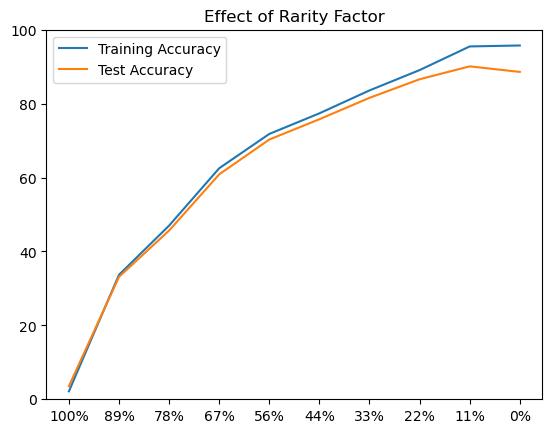

In [14]:
plt.title('Effect of Rarity Factor')
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xticks(range(len(rarity_factors)), ["%.0f%%" % (100 * f) for f in rarity_factors])
plt.ylim(0, 1)
plt.yticks(list(map(lambda x: x / 5, range(6))), map(lambda x: str(20 * x), range(6)))
plt.legend()
plt.show()

## Effect of Smoothening Factor



In [22]:
train_accuracy, test_accuracy = [], []
smooth_factors = 1 - np.geomspace(0.0001, 0.9999, 10)
for smooth_factor in smooth_factors:
    _model = HiddenMarkovModel(training_corpus, smoothing=smooth_factor, rarity_factor=0.11)
    train_accuracy.append(_model.score(training_corpus))
    test_accuracy.append(_model.score(test_corpus))

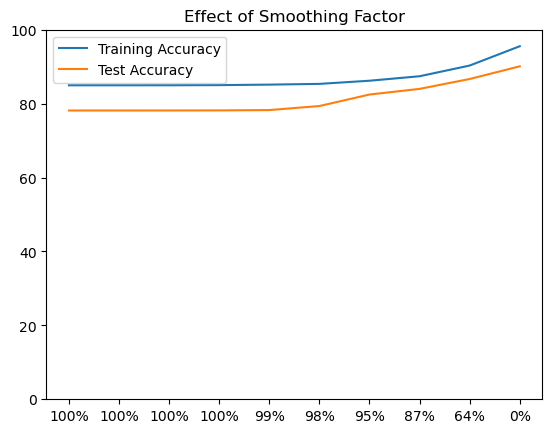

In [23]:
plt.title('Effect of Smoothing Factor')
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xticks(range(len(smooth_factors)), ["%.0f%%" % (100 * f) for f in smooth_factors])
plt.ylim(0, 1)
plt.yticks(list(map(lambda x: x / 5, range(6))), map(lambda x: str(20 * x), range(6)))
plt.legend()
plt.show()

## Effect of Unknown Handlers

In [24]:
model_simple = HiddenMarkovModel(training_corpus, rarity_factor=0.11, smoothing=1e-4, imputer=simple_unknown_imputer)
model_extensive = HiddenMarkovModel(training_corpus, rarity_factor=0.11, smoothing=1e-4, imputer=extensive_unknown_imputer)

train_accuracy_simple = model_simple.score(training_corpus)
train_accuracy_extensive = model_extensive.score(training_corpus)
test_accuracy_simple = model_simple.score(test_corpus)
test_accuracy_extensive = model_extensive.score(test_corpus)

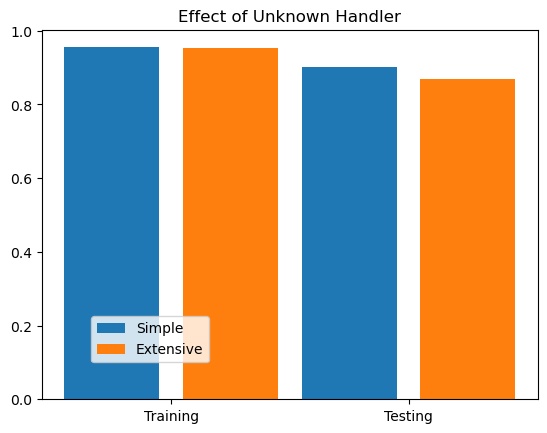

In [49]:
plt.title('Effect of Unknown Handler')
plt.bar([1, 3], [train_accuracy_simple, test_accuracy_simple], label='Simple')
plt.bar([2, 4], [train_accuracy_extensive, test_accuracy_extensive], label='Extensive')
plt.xticks([1.5, 3.5], ['Training', 'Testing'])
plt.legend(loc=(0.1, 0.1))
plt.show()

## Train HMM Model

Create and train a Hidden Markov Model using the Viterbi algorithm.

In [50]:
model = HiddenMarkovModel(training_corpus,
                          algorithm='viterbi',
                          rarity_factor=0.11,
                          smoothing=1e-4,
                          imputer=simple_unknown_imputer)

print(f"Model trained successfully!")
print(f"Number of unique words: {model.n_observations}")
print(f"Number of POS tags: {model.n_hidden_states}")
print(f"POS tags: {model.unique_pos}")

Model trained successfully!
Number of unique words: 18597
Number of POS tags: 17
POS tags: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


## Predict POS Tags

Use the trained model to predict POS tags for test sentences.

In [51]:
predictions = []
for sentence in test_corpus:
    words = [word for word, tag in sentence]
    predicted_tags = model.predict(words)
    predictions.append(list(zip(words, predicted_tags)))

print(f"Made predictions for {len(predictions)} sentences")
print(f"Example prediction: {predictions[0]}")
print(f"Actual tags:        {test_corpus[0]}")

Made predictions for 2077 sentences
Example prediction: [('What', 'PRON'), ('if', 'SCONJ'), ('Google', 'PROPN'), ('Morphed', 'PROPN'), ('Into', 'ADP'), ('GoogleOS', 'NOUN'), ('?', 'PUNCT')]
Actual tags:        [('What', 'PRON'), ('if', 'SCONJ'), ('Google', 'PROPN'), ('Morphed', 'VERB'), ('Into', 'ADP'), ('GoogleOS', 'PROPN'), ('?', 'PUNCT')]


## Evaluate Model Performance

Calculate accuracy scores using micro and macro averaging.

In [52]:
# Evaluate model using score method

from hmm_viterbi import micro_accuracy_score, macro_accuracy_score

micro_acc = model.score(test_corpus, scorer=micro_accuracy_score)
macro_acc = model.score(test_corpus, scorer=macro_accuracy_score)

print(f"Micro Accuracy: {micro_acc:.4f}")
print(f"Macro Accuracy: {macro_acc:.4f}")

Micro Accuracy: 0.9009
Macro Accuracy: 0.8236


## Confusion Matrix

Display confusion matrix to analyze per-class performance.

         ADJ   ADP   ADV   AUX CCONJ   DET  INTJ  NOUN   NUM  PART  PRON PROPN PUNCT SCONJ   SYM  VERB     X
   ADJ  1542     7    40     0     0     4     2    81     2     0     0    50     0     1     0    59     0
   ADP     0  1898    45     0     1     0     0     5     1    44     0     1     0    22     0     7     1
   ADV    58    57  1005     0     2    12     6    13     0     3     8     5     0    14     0     8     0
   AUX     0     0     0  1510     0     0     0     1     1     0     1     1     0     0     0    28     1
 CCONJ     0     1     0     0   731     3     0     1     0     0     0     0     0     0     0     0     0
   DET     0     0    18     0     0  1849     2     0     0     0    25     2     0     0     1     0     0
  INTJ     3     1     2     0     0     1    95     2     0     0     1    11     0     1     0     4     0
  NOUN    94     4     7     3     1     2     4  3656    10     0     0   236     0     0     4   101     1
   NUM    24     0 

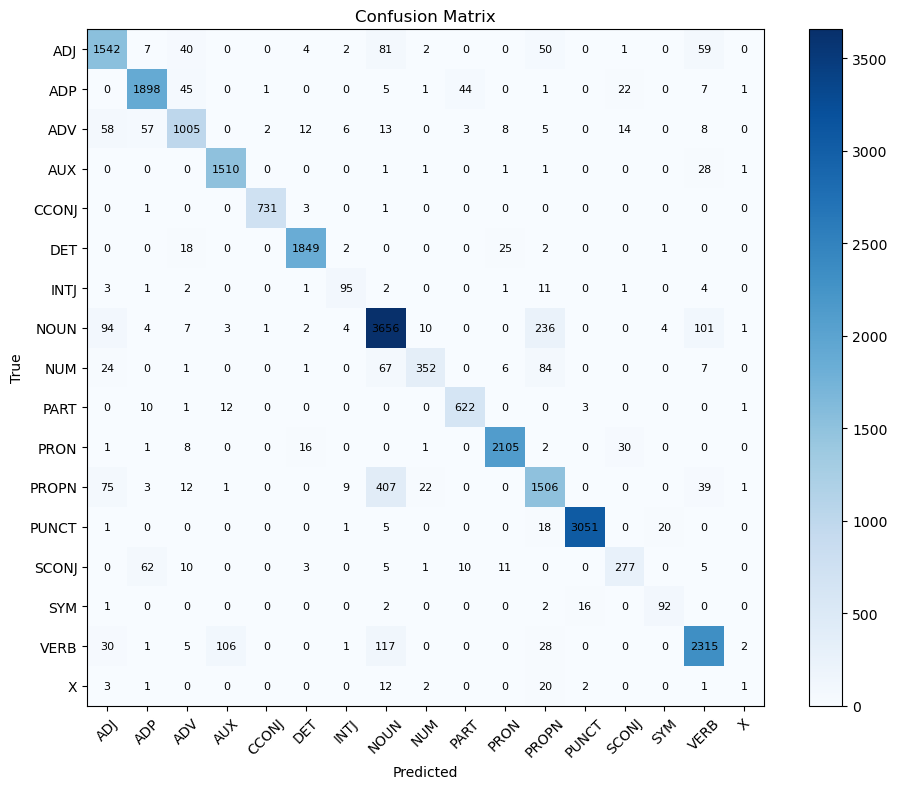

In [53]:
from hmm_viterbi import confusion_matrix, display_confusion_matrix, display_confusion_matrix_heatmap

# Extract true and predicted tags
true_tags = []
predicted_tags = []
for sentence in test_corpus:
    true_tags.extend([tag for word, tag in sentence])

for sentence in predictions:
    predicted_tags.extend([tag for word, tag in sentence])

# Create confusion matrix
cm = confusion_matrix(true_tags, predicted_tags)
display_confusion_matrix(cm)
display_confusion_matrix_heatmap(cm, normalize=False)